In [107]:
import os
import random
import glob
import numpy as np
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from scipy.special import airy
from scipy.stats import norm, sem, gamma
from scipy.optimize import curve_fit
#from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from ipynb.fs.full.model_simulation import plotExitTimesSampled,NormalFormRunner,parameters_,parameters_mouse,MOUSE_SCALE
from tueplots import bundles
from scipy.interpolate import interp1d

fs = 20
bundles.icml2022()
plt.rcParams.update({
    'font.size': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'legend.fontsize': fs
})
matplotlib.rcParams['font.family'] = 'serif'
#matplotlib.rcParams['font.serif'] = ['Liberation Serif']
matplotlib.rcParams['axes.formatter.useoffset'] = False
matplotlib.rcParams['axes.formatter.min_exponent'] = 2
matplotlib.rcParams['axes.formatter.offset_threshold'] = 1
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2022/bin/universal-darwin/'

MODEL_COLOR = '#D81B60'

# vaccine data and data plotting function

In [5]:
vaccine_datasets = dict([(name.split("/")[-1][:-4],pd.read_csv(name)) for name in glob.glob('vaccine_datasets/*')])

In [6]:
def plotVaccineDatasets(ax,datasets,legend=True,gray=False,collapse_log_range=True,plot_err=False):
    def plotDataset(ax,dataset,name,collapse_log_range,gray=False,tmax=10,plot_err=False):
        x=dataset.time.values
        y=dataset.vals.values
        err = dataset.err.values
        x,y,err=x[x<tmax],y[x<tmax],err[x<tmax]
        log_y = np.log(y)
        log_err = np.log(y+err)-np.log(y)
        ci_upper = np.exp(log_y+log_err)
        ci_lower = np.exp(log_y-log_err)
        if collapse_log_range:
            log_y = np.log(y)
            y = np.exp((log_y-log_y.min()) / (log_y.max()-log_y.min()))/np.exp(1)
            errs_final = 0*y
        else:
            norm = y[0]
            y=y/norm
            ci_upper = ci_upper/norm
            ci_lower = ci_lower/norm

            errs_final = [y-ci_lower,ci_upper-y]

        if plot_err:
            if not gray:
                ax.errorbar(x,y,yerr=errs_final,lw=2,label=name,capsize=10)
            else:
                ax.errorbar(x,y,lw=1,yerr=errs_final,label=name,c='gray',capsize=10)
        else:
            if not gray:
                ax.plot(x,y,lw=2,label=name)
            else:
                ax.plot(x,y,lw=1,label=name,c='gray')
    for name in datasets:
        plotDataset(ax,datasets[name],name,collapse_log_range=collapse_log_range,gray=gray,plot_err=plot_err)
    if legend:
        ax.legend(fontsize=fs)
    ax.set_yscale("log")
    
def plot_multi_vaccine_decay(ax,infection): #['Tetanus','Diphtheria', 'Measles', 'Mumps*']
    data=pd.ExcelFile("multi_vaccine_decay/pbio.2006601.s006.xlsx").parse("FigS1_data")
    slopes = []
    intercepts = []
    for tmp in data[data.infection==infection].groupby('indiv'):
        rel_dat = tmp[1]
        rel_dat.loc[:,"age_adj"]=rel_dat.age - rel_dat.age.iloc[0]
        rel_dat.loc[:,"log_titers_normalized"]=np.log(rel_dat.titer.values)
        ax.plot(rel_dat.age,np.exp(rel_dat.log_titers_normalized),c='gray')
        s,intercept = np.polyfit(rel_dat.age,rel_dat.log_titers_normalized,deg=1)
        slopes.append(s)
        intercepts.append(intercept)

    x=np.linspace(20,70,100)
    ax.set_ylim([100,2*10**5])   
    ax.set_xlim([20,70])
    ax.set_yscale('log')
    ax.set_title(infection.replace("*","").lower())

def plot_influenza(ax,c=None,norm=True):
    for s in ("M1","M2","M3","M4"):
        ls = 'solid' if s in ("M1","M2") else 'dashed'
        if c==None:
            c_ = '#1f77b4' if s in ("M1","M2") else '#ff7f0e'
        else:
            c_= c
        Mdat=pd.read_csv("cate_1977/{s}.csv".format(s=s),names=["t","y"]).round()
        if norm:
            Mdat.loc[:,"norm_y"]=Mdat.y/Mdat.y[0]
        else:
            Mdat.loc[:,"norm_y"]=Mdat.y
        ax.plot(Mdat.t,Mdat.norm_y,c=c_,ls=ls,lw=2,label = 'split virus vaccine' if (ls=='dashed') else "whole virus vaccine")

# Figure 1

/var/folders/t5/pz55zt79607_m8z1s6j7bs5m0000gp/T/ipykernel_13308/1968491296.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


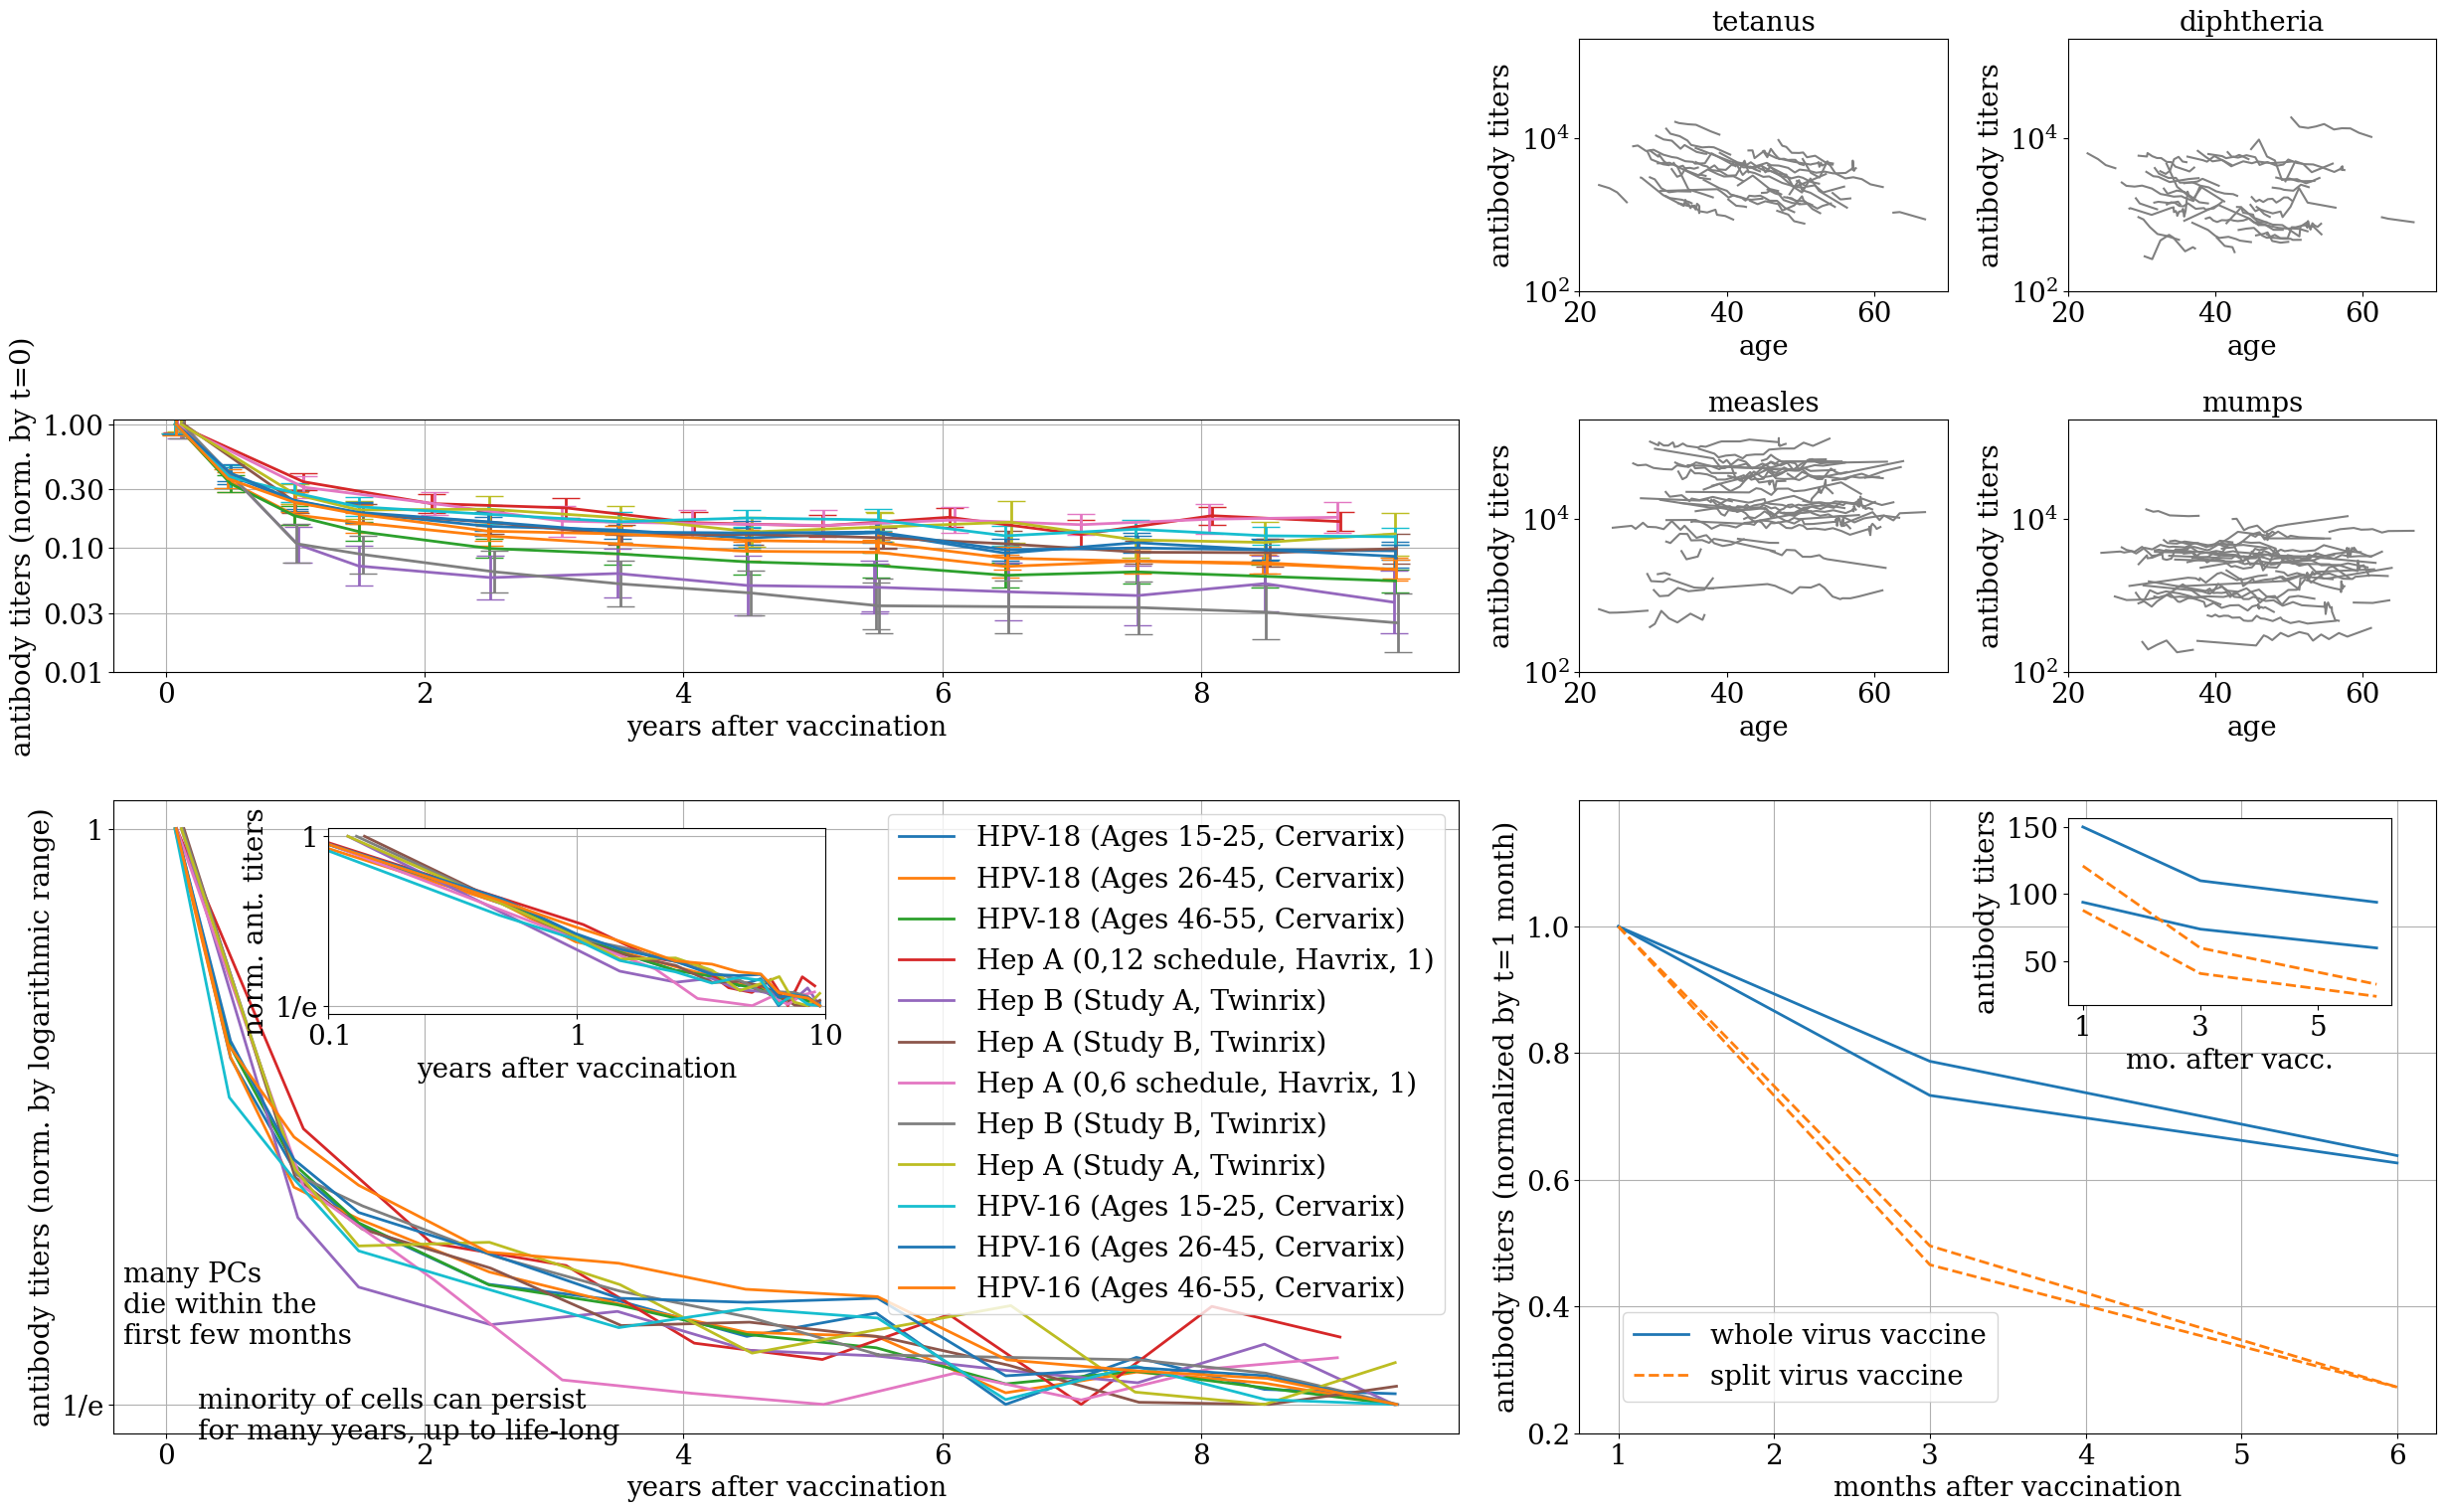

In [7]:
import matplotlib.pyplot as plt

# Define the plot grid layout
#fig = plt.figure(figsize=(22,22*.8))
fig = plt.figure(figsize=(25,25*.75))
grid = fig.add_gridspec(5, 5)

# Create the individual subplots
empty_ = fig.add_subplot(grid[0:1, :-2])

antibody_1 = fig.add_subplot(grid[0, -2])
antibody_2 = fig.add_subplot(grid[0, -1])
antibody_3 = fig.add_subplot(grid[1, -2])
antibody_4 = fig.add_subplot(grid[1, -1])

uncollapsed = fig.add_subplot(grid[1, :-2])
collapsed = fig.add_subplot(grid[2:4, :-2])
influenza = fig.add_subplot(grid[2:4, -2:])
#ax6 = fig.add_subplot(grid[2, 0])

empty_.axis('off')


plotVaccineDatasets(uncollapsed,vaccine_datasets,legend=False,collapse_log_range=False,plot_err=True)
uncollapsed.set_xlabel("years after vaccination")
uncollapsed.set_ylabel("antibody titers (norm. by t=0)")
uncollapsed.yaxis.set_major_formatter(ScalarFormatter())
uncollapsed.yaxis.set_minor_formatter(ScalarFormatter())
uncollapsed.minorticks_off()
uncollapsed.set_ylim([0.02,1.1])
uncollapsed.set_yticks([0.01,.03,0.1,.3,1])
uncollapsed.grid()


plotVaccineDatasets(collapsed,vaccine_datasets)
collapsed.set_xlabel("years after vaccination")
collapsed.set_ylabel("antibody titers (norm. by logarithmic range)")
collapsed.yaxis.set_major_formatter(ScalarFormatter())
collapsed.yaxis.set_minor_formatter(ScalarFormatter())
collapsed.minorticks_off()
collapsed.set_yticks([1/np.exp(1),1])
collapsed.set_yticklabels(["1/e","1"])

collapsed.grid()

plot_multi_vaccine_decay(antibody_1,'Tetanus')
plot_multi_vaccine_decay(antibody_2,'Diphtheria')
plot_multi_vaccine_decay(antibody_3,'Measles')
plot_multi_vaccine_decay(antibody_4,'Mumps*')
for ax in [antibody_1,antibody_2,antibody_3,antibody_4]:
    ax.set_xlabel('age')
    ax.set_ylabel('antibody titers')

    
left, bottom, width, height = [0.14, 0.445, 0.2, 0.1]
collapsed_inset = fig.add_axes([left, bottom, width, height])
plotVaccineDatasets(collapsed_inset,vaccine_datasets,legend=False) #log log plot
collapsed_inset.set_xlim([0.1,10])
collapsed_inset.set_xscale('log')
#ax.set_ylim([1,3])
collapsed_inset.yaxis.set_major_formatter(ScalarFormatter())
collapsed_inset.yaxis.set_minor_formatter(ScalarFormatter())
collapsed_inset.set_xlabel("years after vaccination")
collapsed_inset.set_ylabel("norm. ant. titers")
collapsed_inset.set_xticks([0.1,1,10])
collapsed_inset.set_yticks([1/np.exp(1),1])
collapsed_inset.set_yticklabels(["1/e","1"])
collapsed_inset.grid()
collapsed_inset.minorticks_off()
collapsed_inset.text(0.015,0.05,'many PCs\ndie within the\nfirst few months',fontsize=fs)
collapsed_inset.text(0.03,0.0285,'minority of cells can persist\nfor many years, up to life-long',fontsize=fs)

plot_influenza(influenza)
influenza.set_yticks([.2,.4,.6,.8,1])
influenza.set_ylim([0.2,1.2])
influenza.set_xlabel('months after vaccination')
influenza.set_ylabel('antibody titers (normalized by t=1 month)')
influenza.grid()

left, bottom, width, height = [0.84, 0.45, 0.13, 0.1]
influenza_inset = fig.add_axes([left, bottom, width, height])
influenza_inset.set_xlabel('mo. after vacc.')
influenza_inset.set_ylabel('antibody titers')
influenza_inset.set_xticks([1,3,5])


plot_influenza(influenza_inset,norm=False)

influenza.legend(handles=[influenza.get_lines()[0], influenza.get_lines()[2]],loc=[0.05,0.05])


"""influenza.annotate('E', xy=[-0.1,1], xycoords='axes fraction',
                fontsize=24, fontweight='bold', ha='center', va='center')"""



fig.tight_layout()
#fig.savefig("../figures/fig_1.png",dpi=300)




# Figure 2

In [69]:
ITER_MODE = 10000


def gen_dyn_fig(ax,x,p,arrows_):
    ax.plot(x,x**2+p,c='k')
    #ax.spines['left'].set_position('zero')
    #ax.spines['bottom'].set_position('zero')
    #ax.spines['right'].set_color('none')
    #ax.spines['top'].set_color('none')
    ax.set_yticks([])
    ax.set_xticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(.2)
    ax.annotate("", xy=(0, 0), xytext=(0, p), arrowprops=dict(arrowstyle='<->', linewidth=2, color='red'))
    ax.set_xlabel('$x$', labelpad=10, loc='right')
    ax.set_ylabel('$\dot{x}$', labelpad=10)
    ax.hlines(0,x.min(),x.max(),color='gray')
    ym=.7
    ax.vlines(0,-ym,ym,color='gray')
    ax.set_ylim([-ym,ym])
    for a,b,dir_ in arrows_:
        ax.annotate("", xy=(a, .01), xytext=(b, .01), arrowprops=dict(arrowstyle=dir_, linewidth=4, color='gray'))

def all_dyn_figs(dyn_ax_monostable,dyn_ax_bistable,dyn_ax_ghost):
    x=np.linspace(-2,2,100)
    arrows = [[x.min()*.8,x.max()*.8,'<-'],]
    gen_dyn_fig(dyn_ax_monostable,x,0.5,arrows)

    arrows = [[x.min()*.95,x.min()*.75,'<-'],[x.min()*.65,x.min()*.45,'->'],
              [x.min()*.35,x.max()*.35,'->'],[x.max()*.45,x.max()*.65,'->'],
              [x.max()*.75,x.max()*.95,'<-']]
    gen_dyn_fig(dyn_ax_bistable,x,-0.5,arrows)



    arrows = [[x.min()*.95,x.min()*.75,'<-'],[x.min()*.65,x.min()*.45,'<-'],[x.min()*.35,x.min()*.2,'<-'],[x.min()*.15,x.min()*.08,'<-'],
              [x.min()*.05,x.min()*.02,'<-'],[x.max()*.02,x.max()*.05,'<-'],
              [x.max()*.08,x.max()*.15,'<-'],[x.max()*.2,x.max()*.35,'<-'],[x.max()*.75,x.max()*.95,'<-'],[x.max()*.45,x.max()*.65,'<-']]

    gen_dyn_fig(dyn_ax_ghost,x,0.05,arrows)

    dyn_ax_monostable.set_title('monostable regime, $\mu>0, T=$days/weeks')
    dyn_ax_bistable.set_title('bistable regime, $\mu<0,T=\infty$')
    dyn_ax_ghost.set_title('critical (ghost) regime, long-term $T$')
    
def generate_dy_ghost_basic(ax):
    x=np.linspace(-1,1,100)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')


    arrows = [[x.min()*.95,x.min()*.75,'<-'],[x.min()*.65,x.min()*.45,'<-'],[x.min()*.35,x.min()*.2,'<-'],[x.min()*.15,x.min()*.05,'<-'],
                  [x.min()*.03,x.max()*.03,'<-'],
                  [x.max()*.05,x.max()*.15,'<-'],[x.max()*.2,x.max()*.35,'<-'],[x.max()*.75,x.max()*.95,'<-'],[x.max()*.45,x.max()*.65,'<-']]

    gen_dyn_fig(dyn_ax_ghost_basic,x,0.2,arrows)
    ax.set_ylabel("")
    ax.text(-0.05,0.57,'$\dot{x}$',fontsize=fs)
    ax.set_facecolor("#EEF4FB")
    

def plot_vaccine_fit(ax_fit,ax_fit_inset,iter_=ITER_MODE):
    ax = ax_fit
    std_val=parameters_["MU_STD"]
    t_out,surv_ = NormalFormRunner(parameters_).get_distirbution_of_exit_times_sampled(N=iter_,mu_mean=0,mu_std=std_val,tmax_years=10)
    plotVaccineDatasets(ax,vaccine_datasets,gray=True,legend=False)
    plotExitTimesSampled(ax,t_out,surv_,lw=4,tmax=10,c=MODEL_COLOR)

    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.vlines(200/365,1,3,color='k',lw=.2)
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    
    ax.minorticks_off()

    ax.set_yticks([.4,.5,.6,.7,.8,.9,1])
    ax.set_ylim([.3,1.05])
    
    ax.set_xlabel("years after vaccination")
    ax.set_ylabel("antibody titers (norm. by log range)")
    ax.grid()
    
    ax = ax_fit_inset
    plotVaccineDatasets(ax,vaccine_datasets,gray=True,legend=False)
    plotExitTimesSampled(ax,t_out,surv_,lw=4,tmax=10,c=MODEL_COLOR)
    ax.set_xlim([0.1,10])
    ax.set_xticks([0.1,1,10])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xscale('log')
    ax.vlines(200/365,1,3,color='k',lw=.2)

    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

    ax.set_yticks([.4,.6,.8,1])
    ax.set_ylim([.3,1.05])
    
    ax.set_xlabel("years after vaccination")
    ax.set_ylabel("norm. ant. titers")
    ax.grid()
    
    x = np.linspace(-0.06,0.06,1000)

    ax = gaussian_ax
    # Set ticks at origin
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_yticks([])

    ax.plot(x,norm.pdf(x,loc=0,scale=std_val),c='k',lw=3)
    ax.set_xlabel(r"$\mu$")
    ax.set_ylabel(r"cells (PDF)")


def plot_influenza_fit(ax_influenza,ax_dists,mu_inf_lower=-0.008,mu_inf_upper=0.008,iters=ITER_MODE):
    ax = ax_influenza
    plot_influenza(ax,c='gray')
    std_val = parameters_["MU_STD"]
    t_out,surv_ = NormalFormRunner(parameters_).get_distirbution_of_exit_times_sampled(N=iters,mu_mean=mu_inf_lower,
                                                                                       mu_std=std_val,tmax_years=.5)
    t_out_B,surv_B = NormalFormRunner(parameters_).get_distirbution_of_exit_times_sampled(N=iters,mu_mean=mu_inf_upper,
                                                                                          mu_std=std_val,tmax_years=.5)
    plotExitTimesSampled(ax,12*t_out,surv_,norm=False,lw=4,c=MODEL_COLOR,tmax=100)
    plotExitTimesSampled(ax,12*t_out_B,surv_B,norm=False,lw=4,c=MODEL_COLOR,tmax=100,ls='dashed')

    ax.set_yscale('log')
    ax.set_xlim([1,6])
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.set_ylim([0.25,1])
    ax.set_yticks([0.5,1])
    ax.legend(handles=[ax.get_lines()[0], ax.get_lines()[2]],loc=[0.05,0.05])

    ax.minorticks_off()
    ax.set_xlabel("months after vaccination")
    ax.set_ylabel("antibody titers\n(norm. by t=1 mo)")
    ax.grid()
    
    ax = ax_dists
    
    x=np.linspace(-0.05,0.05,100)
    
    ax.plot(x,norm.pdf(x,loc=mu_inf_lower,scale=std_val),lw=2,ls='solid',color=MODEL_COLOR,label="whole virus vaccine")
    ax.plot(x,norm.pdf(x,loc=mu_inf_upper,scale=std_val),lw=2,ls='dashed',color=MODEL_COLOR,label="split virus vaccine")
    
    ax.set_xticks([-0.04,0,0.04])
    ax.set_xlabel(r"$\mu$")
    ax.set_ylabel(r"cells (PDF)")
    #ax.legend(loc=[0.05,0.05])
    ax.grid()
    



In [70]:
def plot_collapse(ax_collapsed,ax_scaled,ax_orig):
    std_val=parameters_["MU_STD"]
    surv_arr_mu = []
    muvals=np.linspace(-0.002,0.012,5)
    for mu in muvals:
        t_out,surv_ = NormalFormRunner(parameters_).get_distirbution_of_exit_times_sampled(N=ITER_MODE,mu_mean=mu,mu_std=std_val,tmax_years=10)
        surv_arr_mu.append(surv_)

    def gen_x_y(A=0.5,tmax=10):
        for data in vaccine_datasets.values():
            x,y=data.time,data.vals/data.vals.iloc[0]
            x,y = x[(x>A) & (x<tmax)].values,y[(x>A) & (x<tmax)].values
            x_,y_=np.power(np.log(x/A),(4/3)),np.log(y)
            yield x_,y_
        
    plotVaccineDatasets(ax_collapsed,vaccine_datasets,gray=False,legend=False)
    for surv_ in surv_arr_mu:
        y=np.log(surv_)
        y = (y-y.min())/(y.max()-y.min())
        ax_collapsed.plot(t_out,np.exp(y)/np.exp(1),c='k',lw=1) 
    ax_collapsed.set_ylim([0.3,1.01])
    ax_collapsed.set_yticks([np.exp(-1),1])
    ax_collapsed.set_yticklabels(["1/e","1"])
    ax_collapsed.minorticks_off()
    ax_collapsed.set_ylabel("antibody titers\n(S, norm. by log range)")
    for x,y in gen_x_y():
        ax_scaled.plot(x,y,lw=2)
    for surv_ in surv_arr_mu:
        r_t_out,r_surv_ = t_out[t_out>1],surv_[t_out>1]
        ax_scaled.plot(np.log(r_t_out*2)**(4/3),np.log(r_surv_),c='k',lw=1)


    ax_scaled.set_ylabel("$\log{S}$")
    ax_scaled.set_xlabel("$\log^{4/3}{T/A}$")


    plotVaccineDatasets(ax_orig,vaccine_datasets,gray=False,legend=False,collapse_log_range=False)
    for surv_ in surv_arr_mu:
        ax_orig.plot(t_out,surv_,c='k',lw=1)

    ax_orig.set_ylim([0.01,1])
    ax_orig.set_yticks([0.01,0.1,1])
    ax_orig.set_yticklabels(["0.01","0.1","1"])
    ax_orig.set_ylabel("antibody titers\n(S, norm. by t=0)")
    ax_orig.set_xlabel("years after vaccination (T)")
    
    for ax in ax_collapsed,ax_scaled,ax_orig:
        ax.grid()

/var/folders/t5/pz55zt79607_m8z1s6j7bs5m0000gp/T/ipykernel_13308/4250543733.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


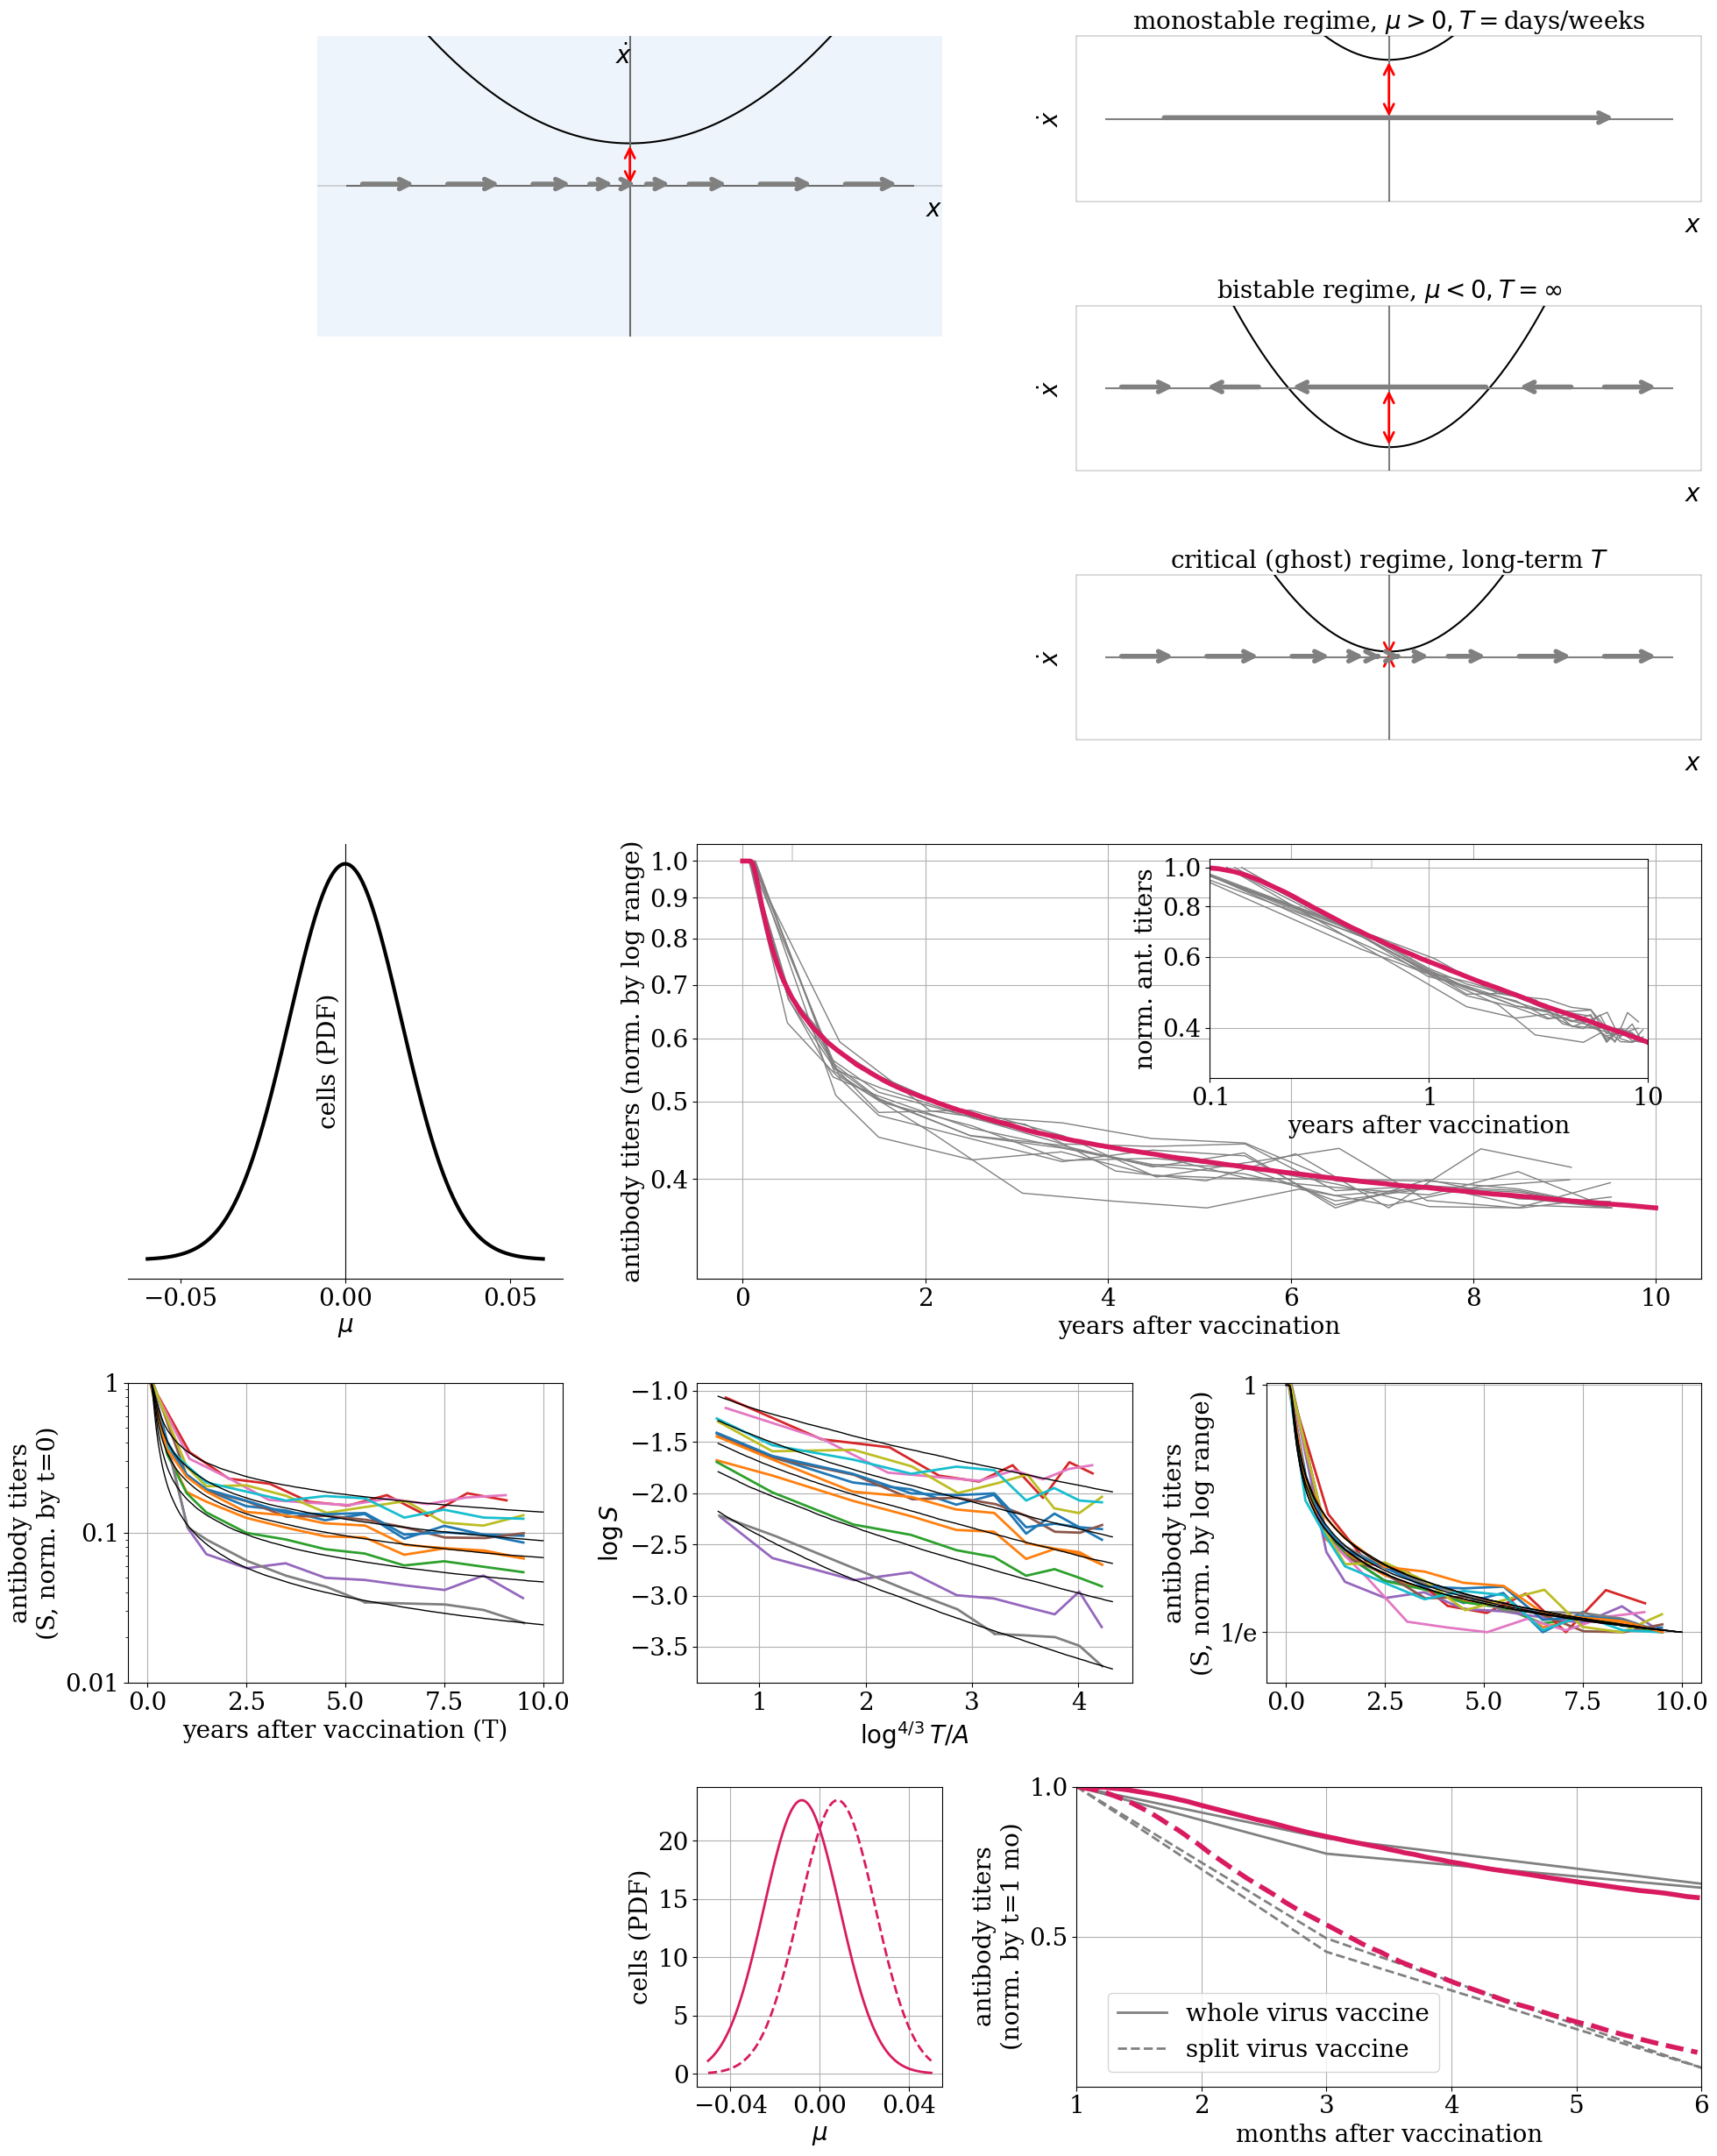

In [71]:
# Define the plot grid layout

fig = plt.figure(figsize=(20,25))
grid = fig.add_gridspec(16, 9)


dyn_ax_ghost_basic= fig.add_subplot(grid[:3, 1:5])

dyn_ax_monostable = fig.add_subplot(grid[0:2, -4:])
dyn_ax_bistable = fig.add_subplot(grid[2:4, -4:])
dyn_ax_ghost = fig.add_subplot(grid[4:6, -4:])



# Create the individual subplots
gaussian_ax = fig.add_subplot(grid[6:10, :3])
fit_ax = fig.add_subplot(grid[6:10, 3:])
empty_ax = fig.add_subplot(grid[13:, 0:2])
dists_ax = fig.add_subplot(grid[13:, 3:-4])
influenza_ax = fig.add_subplot(grid[13:, -4:])

ax_orig = fig.add_subplot(grid[10:13, :3])
ax_scaled = fig.add_subplot(grid[10:13, 3:6])
ax_collapsed = fig.add_subplot(grid[10:13, 6:])






left, bottom, width, height = [0.7, 0.5, 0.25, 0.1]
fit_inset_ax = fig.add_axes([left, bottom, width, height])

all_dyn_figs(dyn_ax_monostable,dyn_ax_bistable,dyn_ax_ghost)

plot_vaccine_fit(fit_ax,fit_inset_ax)

plot_collapse(ax_collapsed,ax_scaled,ax_orig)

plot_influenza_fit(influenza_ax,dists_ax)
generate_dy_ghost_basic(dyn_ax_ghost_basic)

empty_ax.axis('off')





fig.tight_layout()
#fig.savefig("../figures/figure_2.png",dpi=600)


# Figure 3

In [80]:
def load_mice_data():
    data_wt=load_adj("belnoue_blood_2008_april_ko_responses/wt_.csv")
    data_ko=load_adj("belnoue_blood_2008_april_ko_responses/april_ko_.csv")

    norm_fact = data_wt.y.max()
    data_wt.y-=norm_fact
    data_ko.y-=norm_fact
    data_wt.exp_y=data_wt.exp_y/np.power(norm_fact,10)
    data_ko.exp_y=data_ko.exp_y/np.power(norm_fact,10)

    return data_wt,data_ko

def avg_traj(NSS_mult=1,ARR_rate_mult = 1,iterations=10,tmax_years=0.5):
    out_pop= []
    out_mu = []
    age_dist = []
    parameters_B = parameters_mouse.copy()
    parameters_B["NSS"]=parameters_B["NSS"]*NSS_mult
    parameters_B["ARRIVAL_RATE"]=parameters_B["ARRIVAL_RATE"]*ARR_rate_mult
    for i in range(iterations):
        t_,_,hist,state=NormalFormRunner(parameters_B).run_competition(tmax_years=tmax_years)
        out_pop.append(hist["pop_size"])
        out_mu.append(hist["mu_no_adj"])
        age_dist += list(state["age"])
    return hist["t"],np.mean(out_pop,axis=0),np.mean(out_mu,axis=0),age_dist

def extract_mouse_sim_params(MULT_APRIL_DEFICIENCY=3,ITER=10):
    nss_mult_vals = [1, (1+(1/MULT_APRIL_DEFICIENCY))/2, 1/MULT_APRIL_DEFICIENCY]
    AP_KO_pop_sizes_arr = np.array([])
    AP_KO_mu_sizes_arr = np.array([])
    mu_hist = []
    pop_hist=[]
    for nss in nss_mult_vals:
        t,out_pop,out_mu,_ = avg_traj(nss,iterations=ITER,tmax_years=24*7/365)
        t_ind = t>16*7/365
        AP_KO_pop_sizes_arr =np.append(AP_KO_pop_sizes_arr,out_pop[t_ind].mean())
        AP_KO_mu_sizes_arr =np.append(AP_KO_mu_sizes_arr,out_mu[t_ind].mean())
        mu_hist.append(out_mu)
        pop_hist.append(out_pop)
    return AP_KO_pop_sizes_arr,AP_KO_mu_sizes_arr,t,mu_hist,pop_hist

def get_mouse_decay_curves(MU_WT,MU_KO,ITER=10000):
    t_out,surv_ = NormalFormRunner(parameters_mouse).get_distirbution_of_exit_times_sampled(N=ITER,mu_mean=MU_WT,
                                                                                        mu_std=parameters_mouse["MU_STD"],tmax_years=1)

    t_out_B,surv_B = NormalFormRunner(parameters_mouse).get_distirbution_of_exit_times_sampled(N=ITER,mu_mean=MU_KO,mu_std=parameters_mouse["MU_STD"],tmax_years=1)

    return t_out,surv_,surv_B


# human
def est_buildup(iterations=10,max_years=5):
    hist_arr = []
    for i in range(iterations):        
        t_,_,hist,state=NormalFormRunner(parameters_).run_competition(tmax_years=max_years)
        hist_arr.append(hist["repertoire_size"]/parameters_["ID_RANGE"])
    return hist["t"],np.mean(hist_arr,axis=0)


def sim_human(ITER=10000):
    t_human,_,hist_human,_=NormalFormRunner(parameters_).run_competition(tmax_years=80)
    human_surv_arr = []
    a1_arr,a2_arr=[20,30,40],[30,40,50]
    for a1,a2 in zip(a1_arr,a2_arr):
    #for a1,a2 in zip([25,35,45],[34,44,54]):
        m = hist_human["mu_no_adj"][(hist_human["t"]>a1) & (hist_human["t"]<a2)].mean()
        human_t_out,surv_ = NormalFormRunner(parameters_).get_distirbution_of_exit_times_sampled(N=ITER,mu_mean=m,
                                                                                       mu_std=parameters_["MU_STD"],tmax_years=10)
        human_surv_arr.append(surv_)

    return t_human,hist_human,human_t_out,human_surv_arr,a1_arr,a2_arr

In [102]:
def plot_comparative_scaled_mouse_figure(ax):
    t_wt = data_wt.t/365
    y_wt = np.power(10,data_wt.y)
    ax.plot(t_wt*MOUSE_SCALE,y_wt,c='k',lw=5,label="mouse (time %d-fold scaled)" % MOUSE_SCALE)
    plotVaccineDatasets(ax,vaccine_datasets,gray=True,legend=False,collapse_log_range=False)
    ax.set_ylim([0.02,1.1])
    ax.set_xticks([1,2,3,4,5])
    ax.set_xlim([0,4])
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.minorticks_off()
    ax.set_yticks([0.02,0.05,0.2,0.5,1])
    ax.grid()
    ax.get_lines()[1].set_label("human vaccines")
    ax.legend(handles=[ax.get_lines()[0],ax.get_lines()[1]],fontsize=fs,loc='upper right')
    
    
def plot_mouse_antibody_decay(ax,t_mouse_decay,surv_mouse_decay_WT,surv_mouse_decay_KO):

    t=np.linspace(0,data_wt.t.iloc[3],100)

    ax.plot(365*t_mouse_decay,np.log10(surv_mouse_decay_WT),c=MODEL_COLOR,lw=4,label="APRIL$^{+/+}$ (model)")
    ax.plot(365*t_mouse_decay,np.log10(surv_mouse_decay_KO),c=MODEL_COLOR,lw=4,ls='dashed',label="APRIL$^{-/-}$ (model)")
    ax.errorbar(data_wt.t,data_wt.y,yerr=data_wt.err,lw=3,c='gray', ecolor='gray', capsize=10,label="APRIL$^{+/+}$ (experiment)")
    ax.errorbar(data_ko.t,data_ko.y,yerr=data_ko.err,lw=3,c='gray', ecolor='gray', capsize=10,ls='dashed',label="APRIL$^{-/-}$ (experiment)")

    ax.set_ylim([-3.5,0.4])
    ax.set_yticks([-3,-2,-1,0])
    ax.set_xlim([0,225])
    ax.set_xlabel("days")
    ax.set_ylabel("antibody titers (log10, norm. by t=0)")
    ax.legend(loc='upper right',ncol=2)
    ax.grid()

    
def plot_mouse_population(ax,AP_KO_pop_sizes_arr):
    data=pd.read_csv("benet_et_all_cell_reports_2022/data.csv",header=None,names=["x","y"])
    mean_vals = data.groupby("x").apply(lambda x: x.mean().y).values
    data.y = data.y/mean_vals[0]


    ax.bar(x=data.x.unique(),height=mean_vals/mean_vals[0],\
           yerr=data.groupby("x").apply(lambda x: sem(x)[-1]).values,\
           width=.1, edgecolor='gray', color='None', ecolor='gray', capsize=10)
    ax.scatter(data.x,data.y,c='gray')
    x=np.array([1,2,3])
    data_fit = np.polyfit(x-1,mean_vals/mean_vals[0],deg=1)
    y=data_fit[1]+data_fit[0]*(x-1)
    ax.plot(x,AP_KO_pop_sizes_arr/AP_KO_pop_sizes_arr[0],c=MODEL_COLOR,lw=5,ls='dotted',label="mouse model")
    ax.set_ylim([0.1,1.5])
    ax.set_xlim([0.5,3.5])
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(["APRIL$^{+/+}$","APRIL$^{+/-}$","APRIL$^{-/-}$"])
    ax.set_xlabel("")
    ax.set_ylabel("plasma cells (norm.)")
    ax.grid()

    
def plot_dyn_mice(ax,AP_KO_mu_sizes_arr):
    x=np.linspace(-1,1,1000)
    ax.set_ylim([-.02,.1])
    ax.set_yticks([0,0.1])
    ax.set_xticks([-1,0,1])
    ax.plot(x,x**2+mouse_mean_A,c=MODEL_COLOR,lw=3,label="APRIL$^{+/+}$")
    ax.plot(x,x**2+mouse_mean_B,c=MODEL_COLOR,lw=3,ls='dashed',label="APRIL$^{-/-}$")


def plot_dist_mice(ax,AP_KO_mu_sizes_arr):
    mouse_mean_A,mouse_mean_B = AP_KO_mu_sizes_arr[0],AP_KO_mu_sizes_arr[-1]
    mouse_STD = parameters_mouse["MU_STD_POP"]
    
    x=np.linspace(-.1,.1,100)

    ax.plot(x,norm.pdf(x,mouse_mean_A,mouse_STD),c=MODEL_COLOR,lw=1,label="APRIL$^{+/+}$")
    ax.plot(x,norm.pdf(x,mouse_mean_B,mouse_STD),c=MODEL_COLOR,lw=1,ls='dashed',label="APRIL$^{-/-}$")
    ax.vlines(mouse_mean_A,0,norm.pdf(mouse_mean_A,mouse_mean_A,mouse_STD),color=MODEL_COLOR,linestyle='dotted')
    ax.vlines(mouse_mean_B,0,norm.pdf(mouse_mean_B,mouse_mean_B,mouse_STD),color=MODEL_COLOR,linestyle='dotted')
    
    ax.set_ylim([0,20])
    ax.set_xticks([-.1,0,.1])
    ax.set_yticks([])
    ax.set_ylabel("cells (PDF)")
    ax.set_xlabel("$\mu$", labelpad=-5)

def plot_pop_inset(fit_inset_ax,pop_hist,AP_KO_pop_sizes_arr):
    fit_inset_ax.plot(t,pop_hist[0]/AP_KO_pop_sizes_arr[0],c=MODEL_COLOR,lw=1,label="APRIL$^{+/+}$")
    fit_inset_ax.plot(t,pop_hist[-1]/AP_KO_pop_sizes_arr[0],c=MODEL_COLOR,lw=1,label="APRIL$^{-/-}$",ls='dashed')
    fit_inset_ax.legend(bbox_to_anchor=(0.3, 1.08))
    fit_inset_ax.set_ylabel("plasma cells")
    fit_inset_ax.set_xlabel("days")
    
    
def plot_buildup(buildup_fig,buildup,t_bu):
    def get_mina_data():
        ewi = pd.read_csv("Mina_2015/mina_2015_england_wales_prop_immunomodulation_S5.csv",header=None,names=["x","y"]).sort_values("x")
        ewi.x = ewi.x/12

        bacdeath = pd.read_csv("Mina_2015/mina_2015_death_bacterial_infections_who_figss2b.csv",header=None,names=["x","y"]).sort_values("x")
        bacdeath.loc[:,"adj_y"] = (bacdeath.y-bacdeath.y.min())/(bacdeath.y.max()-bacdeath.y.min())
        gamma_cdf = 1-gamma.cdf(ewi.x,a=35,scale=28.5/35) # this is the mina gamma fit
        bacdeath.x = bacdeath.x/12

        return ewi,bacdeath
    ax = buildup_fig
    ax2 = ax.twinx()
    ax.plot(t_bu,buildup/buildup.max(),c=MODEL_COLOR,lw=2,linestyle='solid',label="human model")

    ax.set_ylabel("norm. immune repertoire")
    ax.set_xlabel("years")

    ewi,bacdeath=get_mina_data()
    ax2.plot(ewi.x,ewi.y,c='k',lw=2,linestyle='dashed',label='post measles')
    ax2.plot(bacdeath.x,(bacdeath.y-bacdeath.y.min())/(bacdeath.y.max()-bacdeath.y.min()),c='r',lw=2,linestyle='dashed', label='under 5 / bac. disease')

    ax.set_ylim([0,1])
    ax2.set_ylabel("immunomodulation")
    ax2.set_yticks([0,.2,.4,.6,.8,1])
    ax2.legend(loc='lower right')
    ax.legend(loc='upper right')
    ax.grid()

def plot_human(ax,t_human,hist_human):
    ax.plot(hist_human["t"],hist_human["mu_no_adj"],c=MODEL_COLOR,lw=1,label="human model")
    ax.set_ylim([-0.05,0.2])
    ax.set_yticks([0,0.1,0.2])
    ax.hlines(0,0,hist_human["t"].max(),color='k',ls='dashed',lw=1)
    ax.set_xlabel("age (years)")
    ax.set_ylabel("distance from bifurcation ($\mu$)")
    ax.text(-0.01,0.02,"self-tuning to the\nvicinity of $\mu=0$",fontsize=fs)
    ax.legend(loc='lower right')
    ax.grid()

def plot_human_inset(ax,human_t_out,human_surv_arr,a1_arr,a2_arr):
    for surv_,a1,a2 in zip(human_surv_arr,a1_arr,a2_arr):
        ax.plot(human_t_out,surv_,label="ages %d-%d" % (a1,a2))

    ax.legend()

    ax.set_yscale('log')
    ax.set_xlabel("years after vaccine")
    ax.set_ylabel("norm. antibody titers")
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.grid()
    ax.minorticks_off()
    ax.set_ylim([0.01,1.1])
    ax.set_yticks([0.01,.05,0.1,.5,1])





In [93]:
data_wt,data_ko = load_mice_data()

AP_KO_pop_sizes_arr,AP_KO_mu_sizes_arr,t,mu_hist,pop_hist=extract_mouse_sim_params()
t_mouse_decay,surv_mouse_decay_WT,surv_mouse_decay_KO = get_mouse_decay_curves(AP_KO_mu_sizes_arr[0],AP_KO_mu_sizes_arr[-1])

t_human,hist_human,human_t_out,human_surv_arr,a1_arr,a2_arr = sim_human()
t_bu,buildup = est_buildup()

/var/folders/t5/pz55zt79607_m8z1s6j7bs5m0000gp/T/ipykernel_13308/1105472534.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


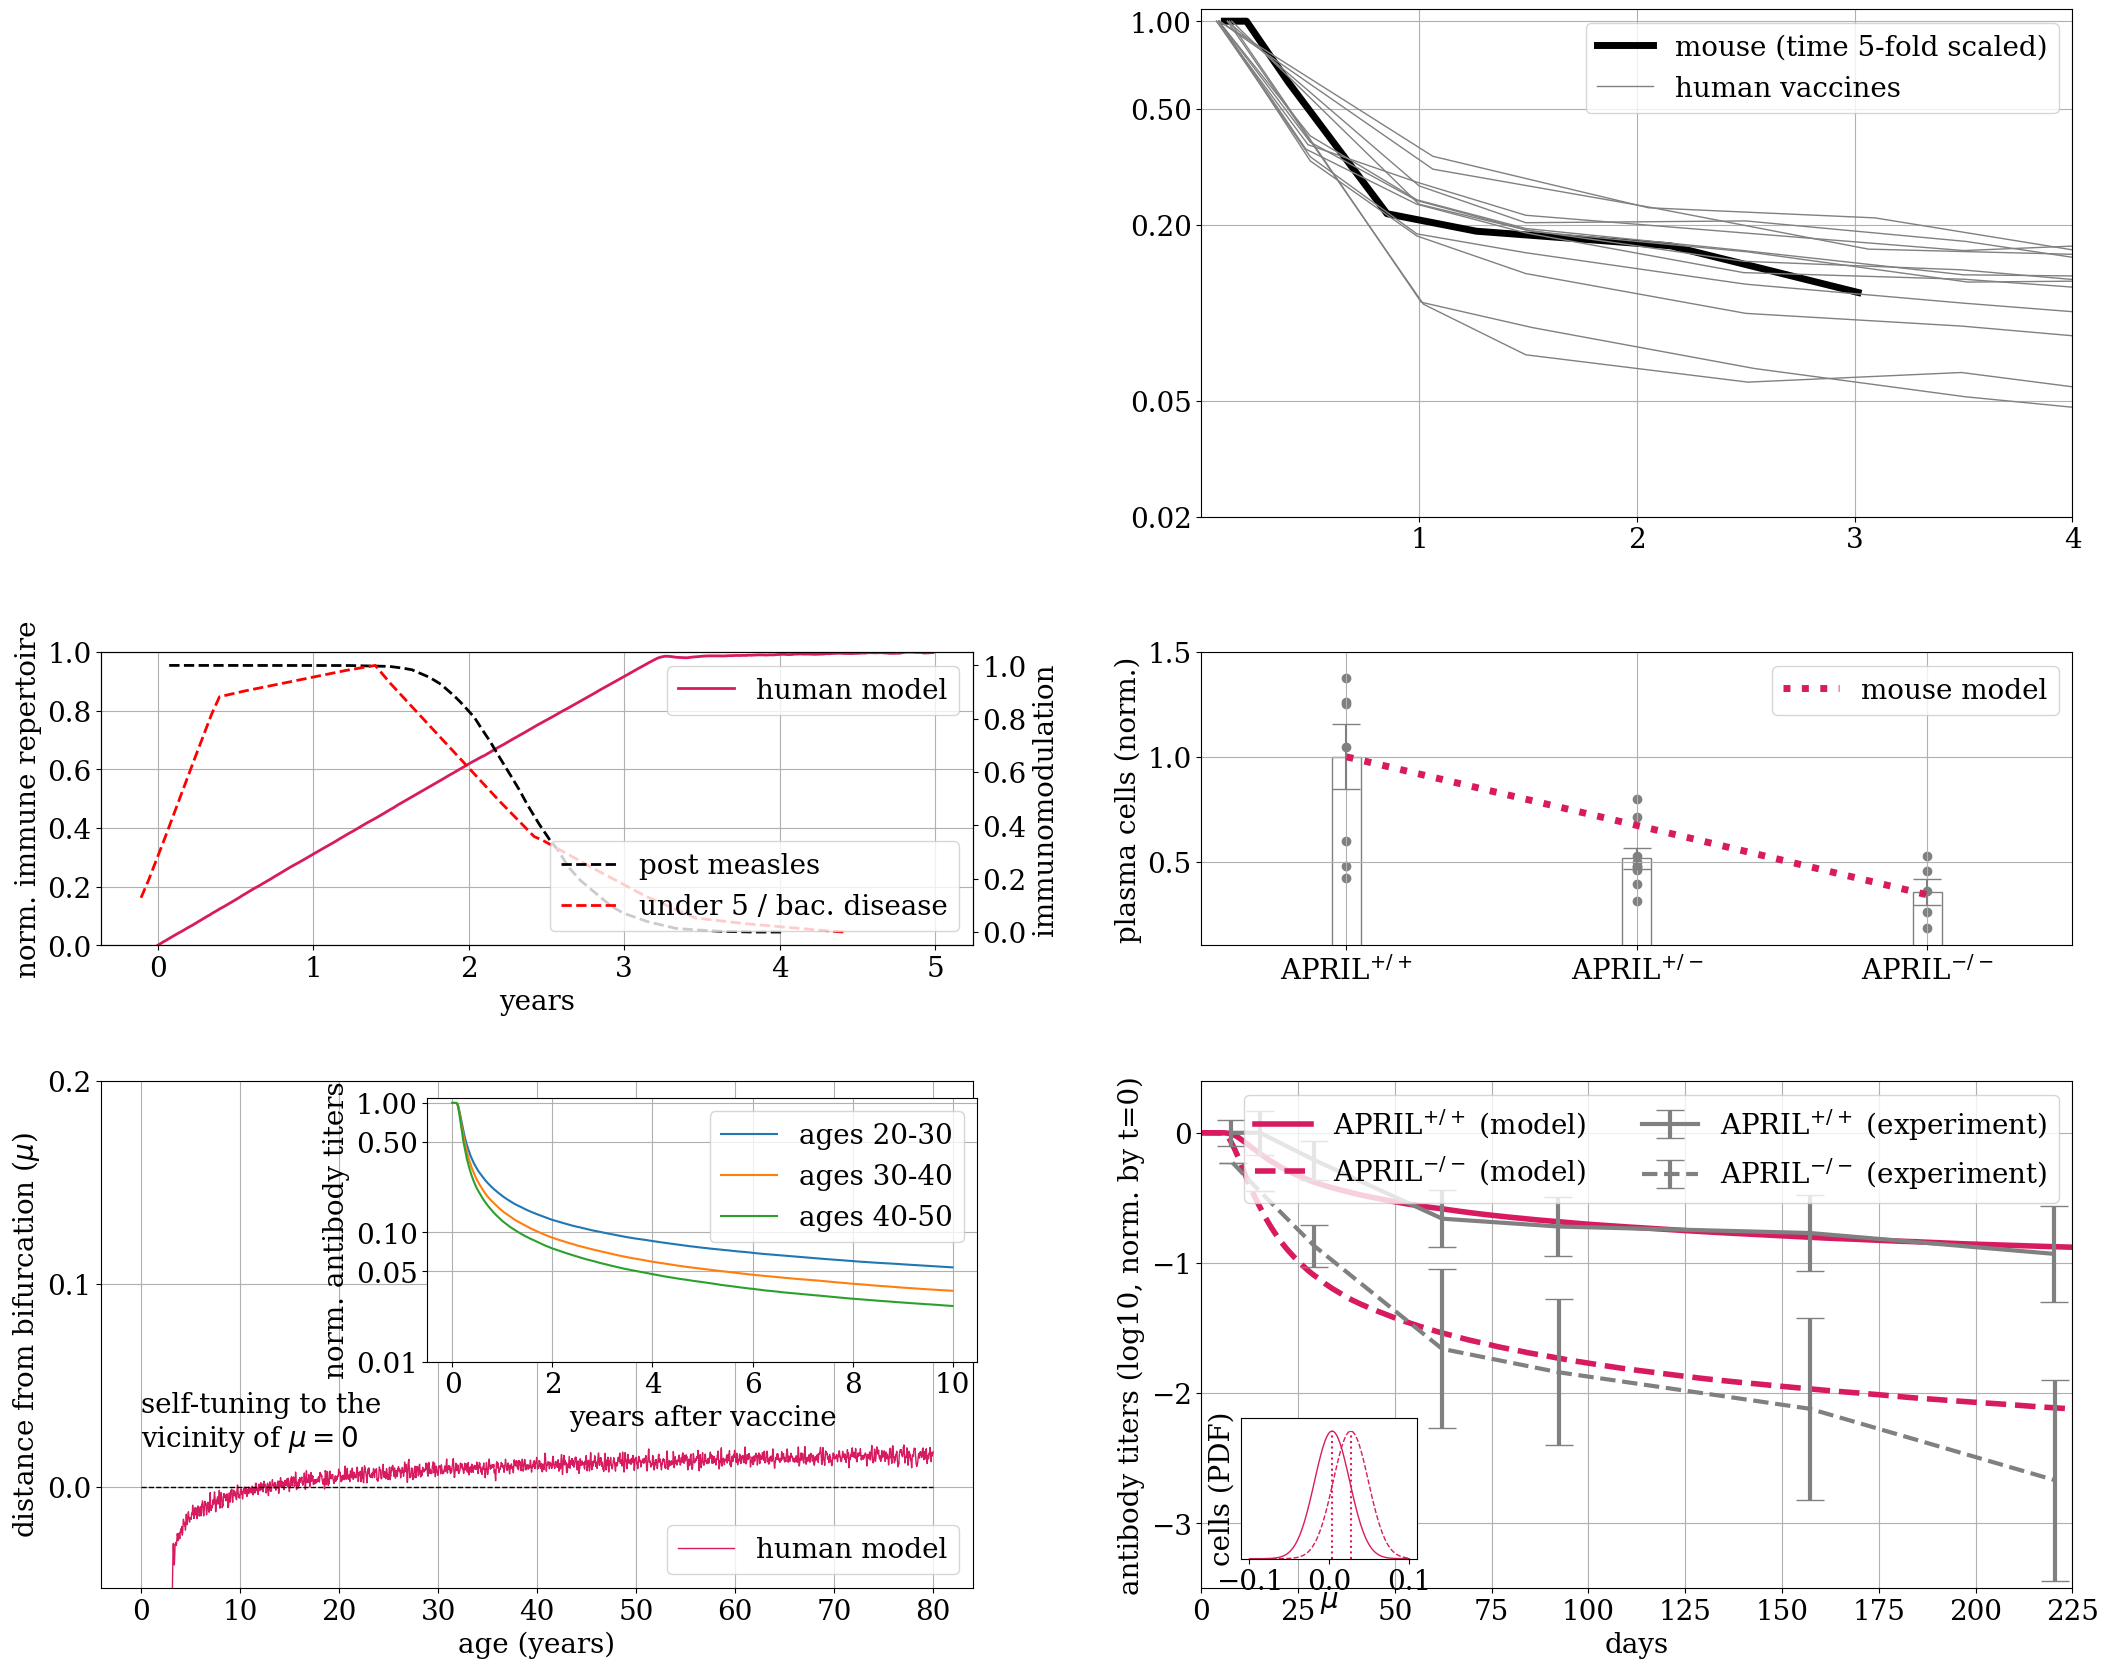

In [103]:
fig = plt.figure(figsize=(22,22*.8))
grid = fig.add_gridspec(8, 4)

empty_ = fig.add_subplot(grid[:3, 0:2])
mouse_comparative = fig.add_subplot(grid[:3, -2:])
mouse_pop = fig.add_subplot(grid[3:5, -2:])
mouse_decay = fig.add_subplot(grid[5:, -2:])

buildup_fig = fig.add_subplot(grid[3:5, :-2])
so_fig = fig.add_subplot(grid[5:,:-2])

empty_.axis('off')
plot_comparative_scaled_mouse_figure(mouse_comparative)
plot_mouse_antibody_decay(mouse_decay,t_mouse_decay,surv_mouse_decay_WT,surv_mouse_decay_KO)
plot_mouse_population(mouse_pop,AP_KO_pop_sizes_arr)
mouse_pop.legend()

left, bottom, width, height = [0.585, 0.088, 0.08, 0.08]
fit_inset_ax = fig.add_axes([left, bottom, width, height])
plot_dist_mice(fit_inset_ax,AP_KO_mu_sizes_arr)


plot_buildup(buildup_fig,buildup,t_bu)


plot_human(so_fig,t_human,hist_human)


left, bottom, width, height = [0.215, 0.2, 0.25, 0.15]
ax = fig.add_axes([left, bottom, width, height])

plot_human_inset(ax,human_t_out,human_surv_arr,a1_arr,a2_arr)
fig.tight_layout(pad=2.0)
#fig.savefig("../figures/figure_3.png",dpi=600)


# Figure 4

In [104]:
ARRIVAL_RATE_MULT =10
ITER=10000
t,op,om,age_dist=avg_traj(NSS_mult=1,ARR_rate_mult=1,iterations=10)
t,op_B,om_B,age_dist_B=avg_traj(NSS_mult=1,ARR_rate_mult=ARRIVAL_RATE_MULT,iterations=10)

t_out,surv_ = NormalFormRunner(parameters_mouse).get_distirbution_of_exit_times_sampled(N=ITER,mu_mean=om[-1],
                                                                                        mu_std=parameters_mouse["MU_STD"],tmax_years=0.5)

t_out_B,surv_B = NormalFormRunner(parameters_mouse).get_distirbution_of_exit_times_sampled(N=ITER,mu_mean=om_B[-1],
                                                                                           mu_std=parameters_mouse["MU_STD"],tmax_years=0.5)



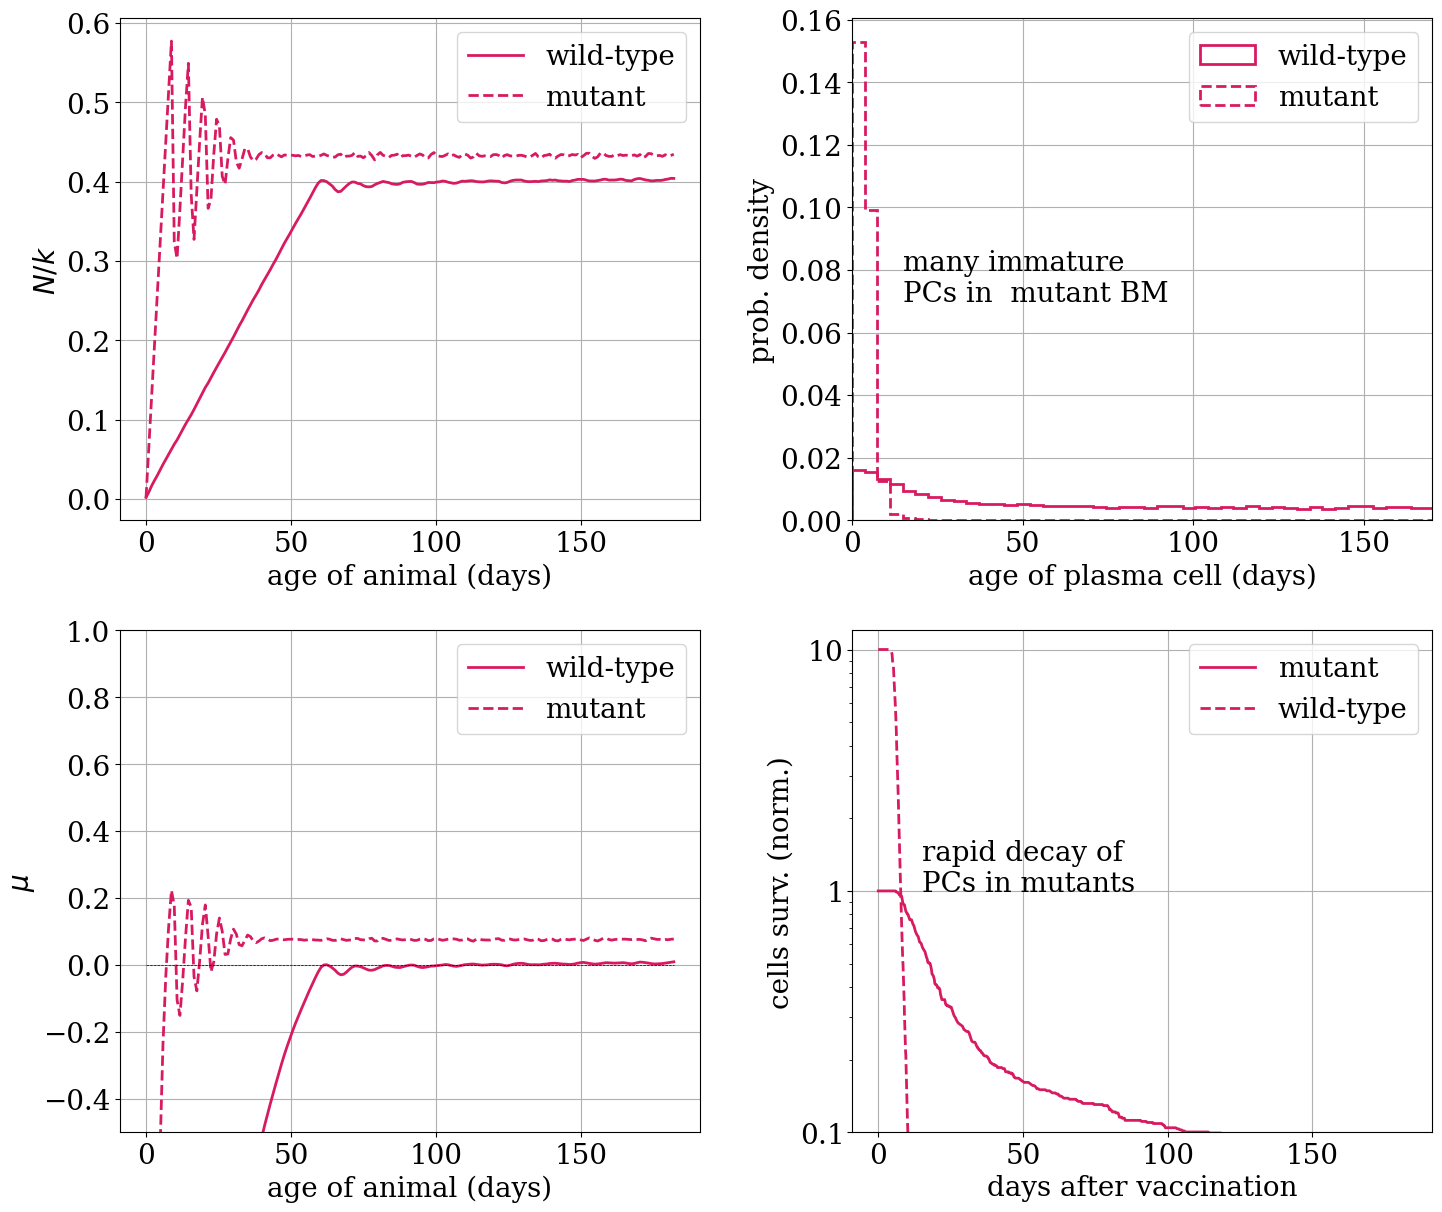

In [106]:

fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(15,15*10/12))
fs=20
ax = axs[0][0]
ax.plot(365*t,op/parameters_["NSS"],c=MODEL_COLOR,lw=2,label='wild-type')
ax.plot(365*t,op_B/parameters_["NSS"],c=MODEL_COLOR,ls='dashed',lw=2,label='mutant')
ax.set_ylabel(r"$N/k$",fontsize=fs)
ax.set_xlabel(r"age of animal (days)",fontsize=fs)
ax.legend()
ax.grid()


ax = axs[1][0]
ax.plot(365*t,om,c=MODEL_COLOR,lw=2,label='wild-type')
ax.plot(365*t,om_B,c=MODEL_COLOR,ls='dashed',lw=2,label='mutant')
ax.set_ylim([-.5,1])
ax.hlines(0,0,365*t.max(),color='k',lw=.5,ls='dashed')
ax.set_ylabel(r"$\mu$",fontsize=fs)
ax.set_xlabel(r"age of animal (days)",fontsize=fs)
ax.legend()
ax.grid()

ax=axs[0][1]
_=ax.hist(np.array(age_dist)*365, bins=np.linspace(0, 365/2, 50), color=MODEL_COLOR,histtype=u'step',density=True,lw=2,label='wild-type')
_=ax.hist(np.array(age_dist_B)*365, bins=np.linspace(0, 365/2, 50), color=MODEL_COLOR,ls='dashed',histtype=u'step',density=True,lw=2,label='mutant')
ax.grid()

ax.legend()
ax.set_xlim([0,170])

ax.set_ylabel(r"prob. density",fontsize=fs)
ax.set_xlabel(r"age of plasma cell (days)",fontsize=fs)
ax.text(15,0.07,'many immature\nPCs in  mutant BM',fontsize=fs)

ax = axs[1][1]
ax.grid()
ax.plot(365*t_out,surv_,lw=2,c=MODEL_COLOR,label='mutant')
ax.plot(365*t_out_B,ARRIVAL_RATE_MULT*surv_B,lw=2,c=MODEL_COLOR,ls='dashed',label='wild-type')
ax.legend()
ax.set_yscale('log')

ax.set_ylabel(r"cells surv. (norm.)",fontsize=fs)
ax.set_xlabel(r"days after vaccination",fontsize=fs)
ax.text(15,1,'rapid decay of\nPCs in mutants',fontsize=fs)

ax.set_ylim([0.1,12])
fig.tight_layout()
#fig.savefig("../figures/gof.png")